In [1]:
### Importing all the neccessary packages ###
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal
from scipy.stats import circmean
from scipy import optimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import intake
import pathlib

import seasonality.seasonalityfunctions as sf
import seasonality.onset_demise as od

In [2]:
### Bombardi et al., 2019 has put the code on github under the MIT license, which allows us to utilize their code in any way we see fit. 
### We will of course credit Bombardi et al., 2019 in the eventual manuscript.

In [3]:
### Allows us to use dask to speed up some calculations ###
from dask.distributed import Client
client = Client()


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61295,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:61306,Total threads: 2
Dashboard: http://127.0.0.1:61312/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:61298,


In [365]:
from importlib import reload
reload(sf)

<module 'seasonality.seasonalityfunctions' from '/Users/gbromley/code/PrecipitationSeasonality/seasonality/seasonalityfunctions.py'>

In [332]:
test_data = np.array([120,180,270,360])


180.00000000000003

In [188]:
catalog_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
col = intake.open_esm_datastore(catalog_url)

col_subset = col.search(frequency=["daily"], component="atm", variable="PRECT",
                        experiment=["20C", "RCP85", "HIST"])

dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")

ds_20C = dsets['atm.20C.daily']['PRECT']

test = ds_20C.sel(lat=46,lon=-105+360,member_id=105, method="nearest").compute()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/var/folders/m4/3slgbrxj3z3dm65l82539j6w0000gq/T/ipykernel_84229/1179976266.py:7: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})



Dataset dictionary keys:
 dict_keys(['atm.HIST.daily', 'atm.20C.daily', 'atm.RCP85.daily'])


In [349]:
import pathlib
file = pathlib.Path('')

if not file.exists():
    

    catalog_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
    col = intake.open_esm_datastore(catalog_url)

    col_subset = col.search(frequency=["daily"], component="atm", variable="PRECT",
                            experiment=["20C", "RCP85", "HIST"])

    dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
    print(f"\nDataset dictionary keys:\n {dsets.keys()}")

    ds_20C = dsets['atm.20C.daily']['PRECT']
    
    test = ds_20C.sel(lat=46,lon=-105+360,member_id=105, method="nearest").compute()

else:
    test = xr.open_dataset("test_cesm.nc")

In [350]:
test

<xarray.Dataset>
Dimensions:    (time: 31390)
Coordinates:
    lat        float64 ...
    lon        float64 ...
    member_id  int64 ...
  * time       (time) object 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
Data variables:
    PRECT      (time) float32 ...

In [351]:
dr = pd.date_range('1920-01-01','2005-12-31', freq='1D')
dates_noleap = dr[(dr.day != 29) | (dr.month != 2)]

test['time'] = dates_noleap
#test = test.sel(time=slice('1996','1998'))
# Renaming datarray to match existing code and changeing from m/s to m
ds_subset = test.rename({'PRECT':'precip'})*86400.0
### Changing data to mm and removing leap days ###
precip = ds_subset['precip']*1000.0
precip = precip.sel(time=~((precip.time.dt.month == 2) & (precip.time.dt.day == 29)))

### Calculating the mean precipitation for each grid point
annual_mean_precip = precip.mean(dim='time')

### Calculating the mean annual cycle ###
annual_precip_cycle= precip.groupby('time.dayofyear').mean(dim='time')

# Pandas creates leap day again with dayofyear use here
annual_precip_cycle = annual_precip_cycle[annual_precip_cycle.dayofyear != 60]
annual_precip_cycle['dayofyear'] = np.arange(1,365+1,1)

annual_precip_cycle_var = precip.groupby('time.dayofyear').std(dim='time')

# Pandas creates leap day again with dayofyear use here
annual_precip_cycle_var = annual_precip_cycle_var[annual_precip_cycle_var.dayofyear != 60]
annual_precip_cycle_var['dayofyear'] = np.arange(1,365+1,1)

### Create Daily precip from hourly ###
##daily_precip = precip.resample(time='1D').sum()

### Create The annual daily precip anomalies ###
annual_means = precip.groupby('time.year').mean(dim='time')


anomalies = precip.groupby('time.year') - annual_means
#anomalies = anomalies_withleap.sel(time=~((anomalies_withleap.time.dt.month == 2) & (anomalies_withleap.time.dt.day == 29)))

climDailyMeanAnomaly = annual_precip_cycle - annual_mean_precip

In [352]:
### Use dask to run the Harmonics finction over the data ### 
# Slightly faster than a loop but still slow ###

start_wet3 = xr.apply_ufunc(
    od.B17_analysis_start,
    annual_precip_cycle,
    input_core_dims=[["dayofyear"]],
    exclude_dims=set(["dayofyear"]),
    vectorize=True,
    dask='parallized',
    output_dtypes=[annual_precip_cycle.dtype]
).values


In [353]:
start_wet3

array(354., dtype=float32)

In [355]:
array_jday = anomalies.time.dt.dayofyear
input_data = anomalies.assign_coords(jday=("time",array_jday.data))

In [356]:
days = np.array(pd.DatetimeIndex(input_data.time).dayofyear)


In [357]:
years = np.array(pd.DatetimeIndex(input_data.time).year)

In [358]:
data = input_data.values

In [359]:
years_ = np.unique(test_index)

In [443]:
len(data)

31390

In [444]:
temp_start_index = np.where(days == startWet)[0]

In [447]:
days[temp_start_index[-1]:]

array([354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365])

In [449]:
len(data[temp_start_index[0]:temp_start_index[-1]])

31026

In [450]:
len(days[:temp_start_index[0]])

352

In [461]:
def LM01_test(data, days, years, startWet):
    
    """
    Summary:
    --------
    Calculates the start of a wet season using the Liebmann and Marengo, 2001 methods. 
    
    Input:
    ------
        data: Daily precipitation anomalies.
        days: Numpy array of day of year (1-365), no leap.
        years: Numpy array of year for each item in days.
        startWet: The doy for when to start the cumulative sum calcuation.
    
    Output:
    -------
        onsetDOY: Array of onset dates. Length is the same as the number of years on input data.

    
    """
    
    if len(days) != len(years):
        raise ValueError('Length of days and years must be the same.')
        
    # Want to make sure we get all the input years before any trimming
    unique_years = np.unique(years)
    
    onsetDOY = np.empty((len(unique_years)))
    onsetDOY[:] = np.nan
    


    # Day of year is missing integer 60 which is February 29th.
    # Need to add zero because a tuple is returned from np.where
    start_index = np.where(days == startWet)[0]
    
    
    ### looping through start dates ###
    for start_day in start_index:
        
        onset_day, onset_year = cumul_anom(data, days, years, start_day)
        
        where_to_place = np.argwhere(unique_years == onset_year)[0][0]
        
        onsetDOY[where_to_place] = onset_day
        
    return onsetDOY

In [455]:
def cumul_anom(data, days, years, start_day, days_in_year=365):
    
    # Day of year is missing integer 60 which is February 29th.
    # Need to add zero because a tuple is returned from np.where
    #start_index = np.where(days == startWet)[0]
    
    # double check we have enough data for last onset calculation
    #if len(days[temp_start_index[-1]:]) < 180:
        
        # trim off data we can't use
        #data_trimmed = data[:temp_start_index[-1]]
        #days_trimmed = days[:temp_start_index[-1]]
        #years_trimmed = years[:temp_start_index[-1]]
            
    # Reindex start days with trimmed days  
    # Need to add zero because a tuple is returned from np.where
    #start_day_index = np.where(days_trimmed == startWet)[0]
    
    
    analysis_begin = start_day
    analysis_end = start_day + days_in_year
    if (analysis_end > len(data)):
        analysis_end = len(data)

    analysis_days = days[analysis_begin:analysis_end]
    analysis_years = years[analysis_begin:analysis_end]
    
    cumsum_data = np.cumsum(data[analysis_begin:analysis_end])
    
    # this returns the index of the data not the day
    onset_index = np.argmin(cumsum_data)
    onset_day = analysis_days[onset_index]
    onset_year = analysis_years[onset_index]
    return onset_day, onset_year #,onset_index


In [493]:
#test_doy = np.array([350, 355, 364,1,3,4])
test_doy = od.onset_LM01(data, days, years, start_wet3)

365.0


TypeError: slice indices must be integers or None or have an __index__ method

In [492]:
LM01_test(data, days, years, start_wet3)

array([ nan, 114., 101., 140.,  76.,  74.,  76.,  78.,  61., 120.,  94.,
       121.,  97., 107., 103., 155.,  92.,  73.,  94., 109.,  87., 115.,
       125.,  85., 115.,  74., 120.,  84.,  81., 102.,  84., 106.,  83.,
        78., 136., 115.,  96.,  94., 117.,  85., 103., 146., 104., 100.,
        78., 126., 119.,  89., 101.,  92.,  72.,  80., 127., 120.,  80.,
       125.,  74., 113., 142.,  56.,  99., 117.,  91.,  83., 108., 101.,
       107., 110.,  93.,  78., 137., 128., 102.,  94., 121., 105., 112.,
       126.,  70., 109.,  78.,  82., 118.,  70., 109., 354.])

In [486]:
sf.check_outliers(test_doy)

array([ 0, 15, 85])

2023-08-30 00:32:00,553 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 31 MB fds: 197>>
Traceback (most recent call last):
  File "/Users/gbromley/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/gbromley/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/distributed/system_monitor.py", line 160, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gbromley/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory


In [527]:
reload(od)
reload(sf)
lm_01 = od.onset_LM01(data[::-1], days[::-1], years[::-1], start_wet3)

In [593]:
reload(sf)
reload(od)

od.onset_B17(data, days, years, start_wet3)

array([ nan, 114., 101., 140.,  76.,  74.,  76.,  78.,  61., 120.,  94.,
       121.,  97., 107., 103.,  50.,  92.,  73.,  94., 109.,  87., 115.,
       125.,  85., 115.,  74., 120.,  84.,  81., 102.,  84., 106.,  83.,
        78., 136., 115.,  96.,  94., 117.,  85., 103., 146., 104., 100.,
        78., 126., 119.,  89., 101.,  92.,  72.,  80., 127., 120.,  80.,
       125.,  74., 113., 142.,  56.,  99., 117.,  91.,  83., 108., 101.,
       107., 110.,  93.,  78., 137., 128., 102.,  94., 121., 105., 112.,
       126.,  70., 109.,  78.,  82., 118.,  70., 109.,  60.])

In [621]:
b17 = od.onset_B17(data, days, years, start_wet3)

In [622]:
lm_01 = od.onset_LM01(data, days, years, start_wet3)

In [625]:
diff = lm_01 - b17

In [628]:
index_diffs = np.argwhere(diff != 0)

In [629]:
index_diffs

array([[ 0],
       [15],
       [85]])

In [634]:
#demise_dates = np.array([pd.to_datetime(i, format='%Y') + pd.Timedelta(k, unit='D') for i,k in zip(years_,test_demise_output#)])
years_ = np.arange(1920,1920+86, step=1)
years_to_plot = np.arange(1920+index_diffs[1]-1,1920+index_diffs[1]+1)
onset_dates = np.array([pd.to_datetime(i, format='%Y') + pd.Timedelta(k, unit='D') for i,k in zip(years_,b17)])

In [572]:
for i,k in zip(years_to_plot,lm_01):
    print(i,k)

1933 nan
1934 114.0
1935 101.0


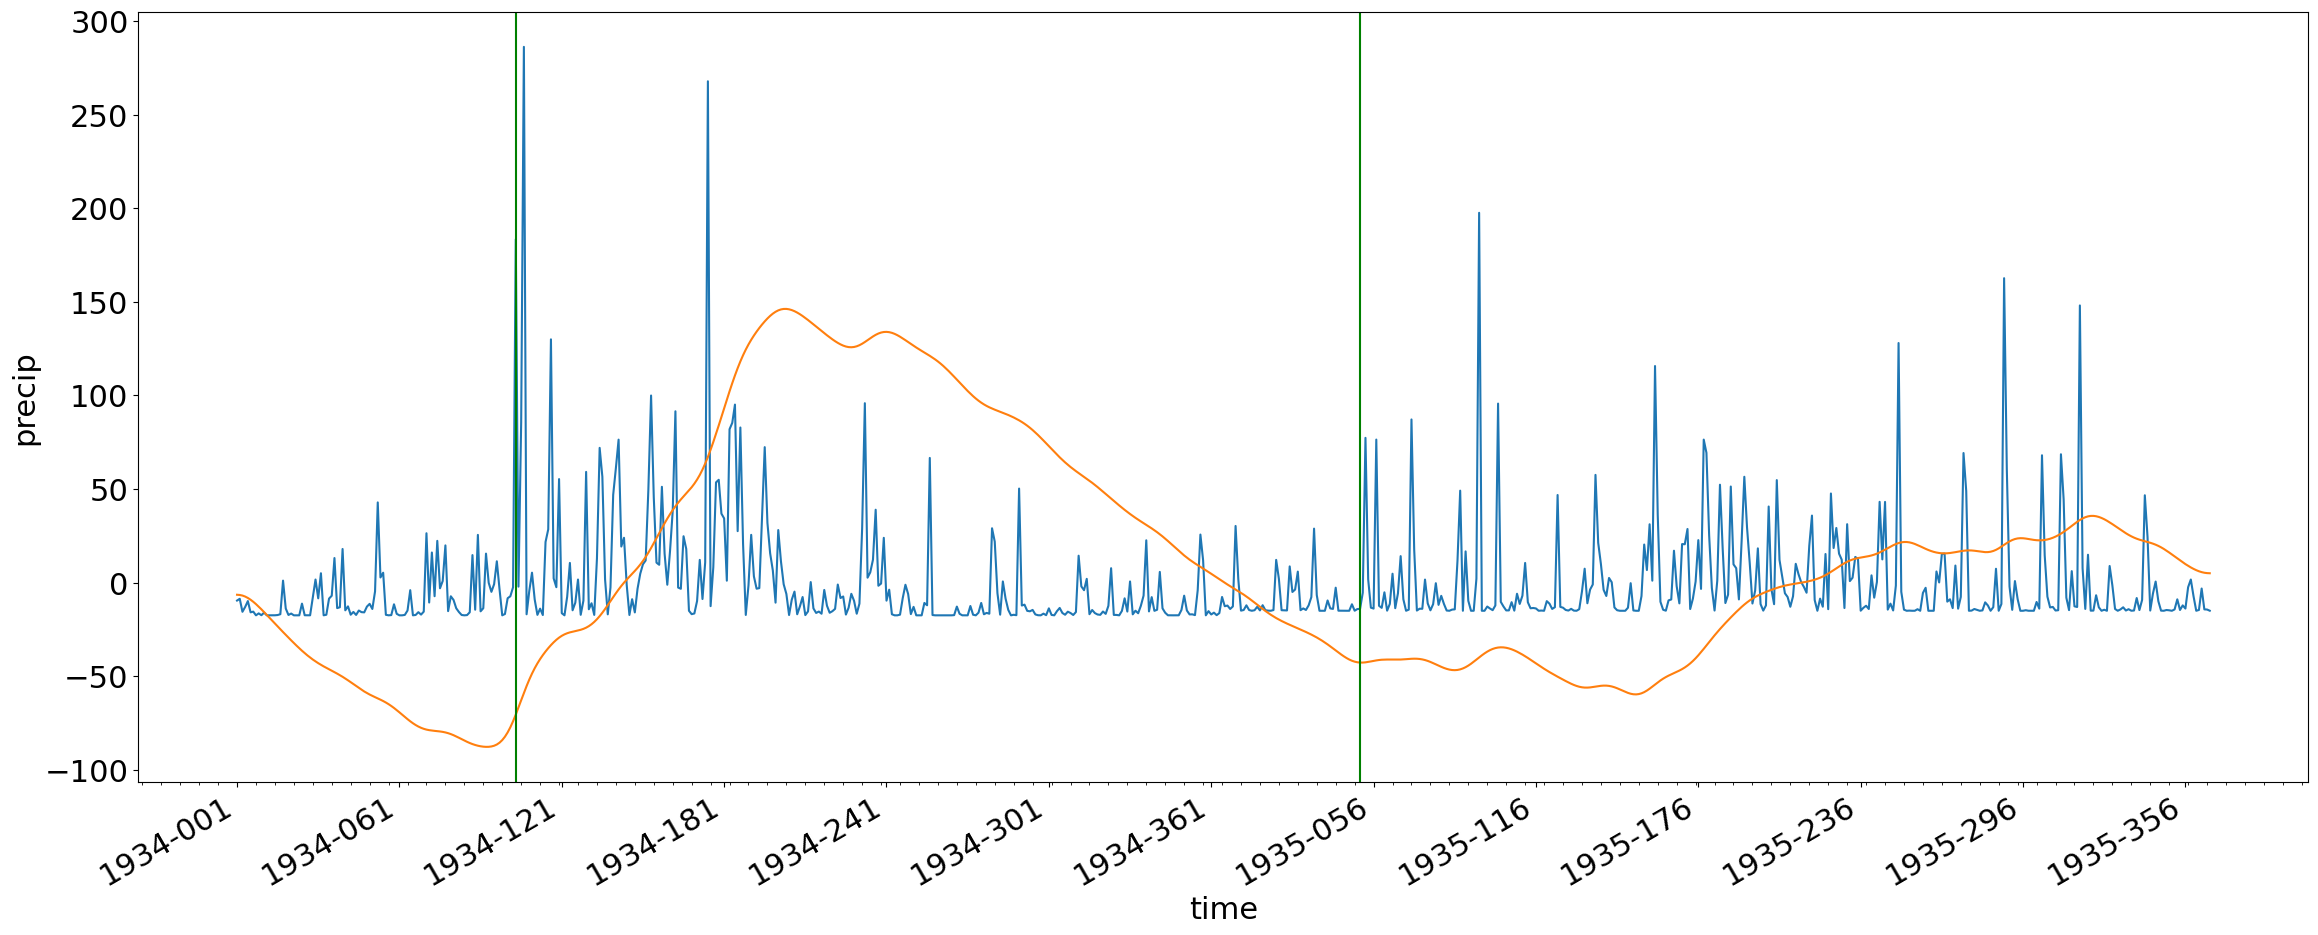

In [635]:
import matplotlib.dates as md
plt.rcParams.update({'font.size': 22})

years_slice = slice(str(years_to_plot[0]),str(years_to_plot[1]))
onset_to_plot = onset_dates[np.flatnonzero(np.isin(years_,years_to_plot))]
#demise_to_plot = demise_dates[np.flatnonzero(np.isin(years_,np.arange(years_to_plot[0],years_to_plot[1]+1)))]
#input_data.assign_coords(jday=("time",input_data['time'].dt.dayofyear.values))
(input_data.sel(time=years_slice)*10).plot(figsize=(28,10))
ax = plt.gca()
ax.plot(input_data.sel(time=years_slice)['time'],sf.smooth_B17(input_data.sel(time=years_slice).cumsum().values))

for i in onset_to_plot:
    plt.axvline(i, color='green') 
#for j in demise_to_plot:
    #plt.axvline(j, color='brown') 
    
date_form = md.DateFormatter("%Y-%j")

ax.xaxis.set_major_locator(md.DayLocator(interval=60))
ax.xaxis.set_minor_locator(md.DayLocator(interval=7))
ax.xaxis.set_major_formatter(date_form)
#ax.set_xlabel(input_data.sel(time=years_slice)['time'].dt.dayofyear.values)

In [94]:
test_lm01[77]

126.0

In [ ]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
#cmap = mpl.cm.RdBu_r


f, ax1 = plt.subplots(1, 1, figsize=(10, 13), dpi=600, subplot_kw={'projection': map_proj})
p = onset_data.dt.dayofyear.isel(year=50).plot.pcolormesh(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='viridis')


### Setting 1st plot parameters ###
ax1.coastlines(color='grey')
ax1.add_feature(cartopy.feature.BORDERS, color='black')
ax1.add_feature(cfeature.STATES, edgecolor='black')
#ax1.set_xticks(np.arange(-180,181, 40))
#ax1.set_yticks(np.arange(-90,91,15))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
at = AnchoredText("a",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
plt.colorbar(p, cax=cax)